<a href="https://colab.research.google.com/github/muyonaise/projects/blob/main/AChE_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cheminformatics projects - Dementia treatments**


Searching Acetylcholinesterase inhibitors and associated chemical descriptors.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2014378/

http://jaoa.org/article.aspx?articleid=2093130#.X7bYwCqy9nY

## **Setting up**

In [ ]:
! pip install kora
! pip install chembl_webresource_client
import kora.install.rdkit

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, Lipinski
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from chembl_webresource_client.new_client import new_client
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## **Functions**

Let's put some functions that we will use in this notebook here for easier reference and also editing

In [ ]:
# to label/group the bioactivity of a molecule
# and append label to a list (2nd argument)
def lbl_act(a, b): # (dataframe, empty list)
  for i in a.standard_value:
    if 10 < float(i) <= 1000:
      b.append("active")
    elif float(i) <= 10:
      b.append("highly active")
    elif float(i) >= 10000:
      b.append("inactive")
    elif 1000 < float(i) < 10000:
      b.append("intermediate activity")

In [ ]:
# convert a smiles to molecules and append to a list
def smile_2_mol(a, b): # (dataframe, empty list)
  for i in a.canonical_smiles:
    mole = Chem.MolFromSmiles(i)
    b.append(mole)

In [ ]:
# a capping function for activity values above 100,000 nM
def cap_activ(a):
  cappd = []

  for i in a['standard_value']:
    if i > 100000000:
      i = 100000000
    else: #not necessary
      i = i
    cappd.append(i)

  a['standard_value'] = cappd

  return a.standard_value.describe()

In [ ]:
# converting IC50s to pIC50s and relabelling the column
def logIC50(a):
  lgIC50 = []
  for i in a['standard_value']:
    lgIC50.append(-np.log10(i*(10**-9))) # could be done in one line but may be confusing
  
  a['standard_value'] = lgIC50
  a.rename(columns={'standard_value':'pIC50'}, inplace = True)

  return a

In [ ]:
# the below function has been adapted from
# https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/ 
def mannwhitney_act_vs_hi_act(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(100)

# actives and inactives
  selection = [descriptor, 'bioactivity']
  df = final_no_int[selection]
  active = df[df['bioactivity'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity']
  df = final_no_int[selection]
  hi_active = df[df['bioactivity'] == 'highly active']
  hi_active = hi_active[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, hi_active)

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject null hyp)'
  else:
    interpretation = 'Different distribution (reject null hyp)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])

  return results

## **Searching for cholinergic enzyme AChE, and drugs known to inhibit its activity**

### **AChE**

Searching the ChEMBL database for Acetylcholinesterase's target report card, the way one might on the web and saving the results to a dataframe.

In [ ]:
tg = new_client.target
search_query = tg.search('AChE')
query_results = pd.DataFrame(search_query)
query_results

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P04058', 'xref_name': None, 'xre...",Torpedo californica,Acetylcholinesterase,23.0,False,CHEMBL4780,"[{'accession': 'P04058', 'component_descriptio...",SINGLE PROTEIN,7787.0
1,"[{'xref_id': 'O42275', 'xref_name': None, 'xre...",Electrophorus electricus,Acetylcholinesterase,23.0,False,CHEMBL4078,"[{'accession': 'O42275', 'component_descriptio...",SINGLE PROTEIN,8005.0
2,"[{'xref_id': 'Q95P20', 'xref_name': None, 'xre...",Musca domestica,Acetylcholinesterase,23.0,False,CHEMBL5752,"[{'accession': 'Q95P20', 'component_descriptio...",SINGLE PROTEIN,7370.0
3,[],Danio rerio,Acetylcholinesterase,23.0,False,CHEMBL3308995,"[{'accession': 'Q9DDE3', 'component_descriptio...",SINGLE PROTEIN,7955.0
4,"[{'xref_id': 'P22303', 'xref_name': None, 'xre...",Homo sapiens,Acetylcholinesterase,17.0,False,CHEMBL220,"[{'accession': 'P22303', 'component_descriptio...",SINGLE PROTEIN,9606.0
5,"[{'xref_id': 'P21836', 'xref_name': None, 'xre...",Mus musculus,Acetylcholinesterase,17.0,False,CHEMBL3198,"[{'accession': 'P21836', 'component_descriptio...",SINGLE PROTEIN,10090.0
6,"[{'xref_id': 'P37136', 'xref_name': None, 'xre...",Rattus norvegicus,Acetylcholinesterase,17.0,False,CHEMBL3199,"[{'accession': 'P37136', 'component_descriptio...",SINGLE PROTEIN,10116.0
7,"[{'xref_id': 'P23795', 'xref_name': None, 'xre...",Bos taurus,Acetylcholinesterase,17.0,False,CHEMBL4768,"[{'accession': 'P23795', 'component_descriptio...",SINGLE PROTEIN,9913.0
8,[],Gallus gallus,Acetylcholinesterase,17.0,False,CHEMBL3227914,"[{'accession': 'P36196', 'component_descriptio...",SINGLE PROTEIN,9031.0
9,[],Rattus norvegicus,Acetylcholinesterase and butyrylcholinesterase...,16.0,False,CHEMBL2111475,"[{'accession': 'P37136', 'component_descriptio...",SELECTIVITY GROUP,10116.0


Lets select the 5th entry for AChE as it's for the protein in humans... although index 6 is also tempting ahah

## **Bioactivity data**

Searching for bioactivity data for AChE. Filtering for activities in units of $IC50$ only. Neglecting $EC50$ to avoid confusion and also $K_d$ and $apparent$ $K_d$ as these values seem to cap at a $10000 nM$ for AAK1 study.

In [ ]:
bioactivity = new_client.activity
ld = bioactivity.filter(target_chembl_id=query_results.target_chembl_id[4]).filter(standard_type="IC50")
df_ld = pd.DataFrame(ld)
len(df_ld)

7026

Saving the raw data to a .csv. Let's not keep the index column

In [ ]:
df_ld.to_csv('AChE_chembl_inhib_ic50_raw.csv', index=False)

### **Cleaning**

Let's clean the data of any duplicates and empty cells and then reset the index again so that we can add matching bioactivity labels to the dataframe.

In [ ]:
df2 = df_ld[df_ld.standard_value.notna()]
df2 = df2[df2.canonical_smiles.notna()]
cleanup = df2.drop_duplicates(subset='molecule_chembl_id', keep='last')
cleanup = cleanup.drop_duplicates(subset='canonical_smiles', keep='last').reset_index()
# turn the activity values to floats
cleanup['standard_value'] = pd.to_numeric(cleanup['standard_value'], downcast="float")

In [ ]:
len(cleanup)

4695

### **Some pre-processing and saving of the data**

The molecule id, smile and its activity are the most important to me

In [ ]:
df_ache = cleanup[['molecule_chembl_id','canonical_smiles','standard_value']]
df_ache.sort_values(by=['standard_value'], ascending=True).head()

,molecule_chembl_id,canonical_smiles,standard_value
3055,CHEMBL3322232,Cl.O=C(NCCCNc1c2c(nc3cc(Cl)ccc13)CCCC2)c1ccc2n...,0.00600
1214,CHEMBL199585,O=C(CCCCCCNc1c2c(nc3cc(Cl)cc(Cl)c13)CCCC2)NCCc...,0.00800
4419,CHEMBL4205425,COc1ccccc1C(=O)N1Cc2cc(NC(=O)c3cccc(Cl)c3)ccc2...,0.01095
4416,CHEMBL4205954,O=C(Nc1ccc2c(c1)CN(C(=O)c1ccccc1)C(=O)C2)c1ccc...,0.01323
4421,CHEMBL4209803,Cc1cccc(C(=O)Nc2ccc3c(c2)CN(C(=O)c2cccc(C)c2)C...,0.01352


### **Grouping bioactivity**

The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be active while those greater than 10,000 nM will be considered to be inactive. As for those values in between 1,000 and 10,000 nM will be referred to as intermediate.

In [ ]:
activity_list = []

In [ ]:
lbl_act(df_ache, activity_list)

In [ ]:
# turn this list into a dataframe
df_lbl_act = pd.Series(activity_list, name='bioactivity')
# and join it up with the pre-processed table
df_ache_lbl = pd.concat([df_ache, df_lbl_act], axis=1)
df_ache_lbl

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,2400.0,intermediate activity
...,...,...,...,...
4690,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,3810.0,intermediate activity
4691,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,3460.0,intermediate activity
4692,CHEMBL4278260,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(C#N)cc3...,2780.0,intermediate activity
4693,CHEMBL3819548,O=C(/C=C/c1ccccc1)NCCC1CCN(Cc2ccccc2)CC1,450.0,active


### **pIC50**

http://cdn2.hubspot.net/hubfs/146552/docs/Why_Using_pIC50_will_Change_Your_Life.pdf?t=1443795935716

In [ ]:
df_ache_lbl.standard_value.describe()

count    4.695000e+03
mean     9.141120e+11
std      4.807910e+13
min      6.000000e-03
25%      1.135000e+02
50%      2.100000e+03
75%      1.577500e+04
max      3.235937e+15
Name: standard_value, dtype: float64

As we can see from the above result the majority of datapoints are under $100,000 nM$, so we will cap the standard_value column as to avoid negative $pIC50$s.

In [ ]:
cap_activ(df_ache_lbl)

count    4.695000e+03
mean     2.267084e+05
std      3.744630e+06
min      6.000000e-03
25%      1.135000e+02
50%      2.100000e+03
75%      1.577500e+04
max      1.000000e+08
Name: standard_value, dtype: float64

Let's convert these IC50s and re-label the column

In [ ]:
logIC50(df_ache_lbl)

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,6.124939,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,7.000000,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,4.301030,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,6.522879,active
4,CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,5.619789,intermediate activity
...,...,...,...,...
4690,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,5.419075,intermediate activity
4691,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,5.460924,intermediate activity
4692,CHEMBL4278260,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(C#N)cc3...,5.555955,intermediate activity
4693,CHEMBL3819548,O=C(/C=C/c1ccccc1)NCCC1CCN(Cc2ccccc2)CC1,6.346787,active


## **Calculating the Lipinski Descriptors and creating our final dataframe**

Calculating the:


*   Molecular weight
*   Octanol-Water partition coeff
*   No. of H-bond donors
*   No. of H-bond acceptors

We can use the smile_2_mols function to convert the canonical smiles into molecule format so we can obtain chemical information from them.

In [ ]:
molecular_data = []
smile_2_mol(df_ache_lbl, molecular_data)

In [ ]:
# create a dataframe with our descriptors
empty = []

for mol in molecular_data:
  descript_mw = Descriptors.MolWt(mol)
  descript_logp = Descriptors.MolLogP(mol)
  descript_hdon = Lipinski.NumHDonors(mol)
  descript_hacc = Lipinski.NumHAcceptors(mol)

  descriptors = ([descript_mw,descript_logp,descript_hdon,descript_hacc])

  empty.append(descriptors)

column_labels = ["MW","LogP","No_H-Donors","No_H-Acceptors"]
df_des = pd.DataFrame(empty, columns=column_labels)
df_des

,MW,LogP,No_H-Donors,No_H-Acceptors
0,312.325,2.80320,0,6
1,376.913,4.55460,0,5
2,426.851,5.35740,0,5
3,404.845,4.70690,0,5
4,338.436,4.07992,0,5
...,...,...,...,...
4690,555.601,7.18140,2,3
4691,521.702,6.32710,2,5
4692,501.715,6.29058,2,4
4693,348.490,4.11830,1,2


In [ ]:
combined_info = pd.concat([df_ache_lbl, df_des], axis=1)
combined_info

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity,MW,LogP,No_H-Donors,No_H-Acceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,6.124939,active,312.325,2.80320,0,6
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,7.000000,active,376.913,4.55460,0,5
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,4.301030,inactive,426.851,5.35740,0,5
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,6.522879,active,404.845,4.70690,0,5
4,CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,5.619789,intermediate activity,338.436,4.07992,0,5
...,...,...,...,...,...,...,...,...
4690,CHEMBL4281727,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,5.419075,intermediate activity,555.601,7.18140,2,3
4691,CHEMBL4292349,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,5.460924,intermediate activity,521.702,6.32710,2,5
4692,CHEMBL4278260,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(C#N)cc3...,5.555955,intermediate activity,501.715,6.29058,2,4
4693,CHEMBL3819548,O=C(/C=C/c1ccccc1)NCCC1CCN(Cc2ccccc2)CC1,6.346787,active,348.490,4.11830,1,2


In [ ]:
combined_info.describe()

,pIC50,MW,LogP,No_H-Donors,No_H-Acceptors
count,4695.000000,4695.000000,4695.000000,4695.000000,4695.000000
mean,5.860243,415.677588,3.996489,1.130351,4.373589
std,1.537450,129.938801,2.510010,1.093443,1.888268
min,1.000000,61.040000,-6.615100,0.000000,0.000000
25%,4.802031,332.844000,2.622600,0.000000,3.000000
50%,5.677781,401.212000,4.113800,1.000000,4.000000
75%,6.945008,484.611000,5.406450,2.000000,6.000000
max,11.221849,1235.463000,13.506800,10.000000,16.000000


In [ ]:
# we write this to a csv file
combined_info.to_csv('AChE_mol_lipinski_desc_pIC50.csv', index=False)

## **Top 20 Most Active Compounds**

Let's have a quick look at what molecules are the most highly active

In [ ]:
HA_data = combined_info.loc[combined_info['bioactivity'] == 'highly active']
HA_data

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity,MW,LogP,No_H-Donors,No_H-Acceptors
12,CHEMBL339995,CSc1nc(/C=C/c2ccccc2)nn1C(=O)N(C)C,8.000000,highly active,288.376,2.70010,0,5
13,CHEMBL335158,CCCCCCSc1nc(-c2ccc(Cl)cc2)nn1C(=O)N1CCCCC1,8.000000,highly active,406.983,5.72490,0,5
108,CHEMBL87170,COc1cc2cc(C(=O)CCc3cc[n+](Cc4ccccc4)cc3)sc2cc1OC,8.337242,highly active,418.538,5.06980,0,4
123,CHEMBL87849,COc1cc2cc(C(=O)CCc3cc[n+](Cc4ccc(F)cc4)cc3)sc2...,8.585027,highly active,436.528,5.20890,0,4
132,CHEMBL87649,COc1cc2cc(C(=O)CCc3cc[n+](Cc4ccsc4)cc3)sc2cc1OC,8.221849,highly active,424.567,5.13130,0,5
...,...,...,...,...,...,...,...,...
4556,CHEMBL4283298,C[N+](C)(CC#CCOC1=NOCC1)CCCCCCCNc1c2c(nc3ccccc...,8.700057,highly active,557.577,2.31020,1,5
4561,CHEMBL4294640,Cn1c2nc3ccccc3c-2c(NCCCCCCCCNc2c3c(nc4ccccc24)...,9.022276,highly active,555.770,9.12290,2,5
4562,CHEMBL4284047,Cn1c2nc3ccccc3c-2c(NCCCCCCNc2c3c(nc4ccccc24)CC...,8.903090,highly active,527.716,8.34270,2,5
4564,CHEMBL4280612,Nc1c2c(nc3cc(Cl)ccc13)C[C@H]1C=C(CCCCn3cc(CO)n...,9.366532,highly active,423.948,4.40080,2,6


In [ ]:
# there are 400 of them so let's just inspect the top 20 maybe
HA_data_20 = HA_data.sort_values(by=['pIC50'], ascending=False).head(20)
HA_data_20

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity,MW,LogP,No_H-Donors,No_H-Acceptors
3055,CHEMBL3322232,Cl.O=C(NCCCNc1c2c(nc3cc(Cl)ccc13)CCCC2)c1ccc2n...,11.221849,highly active,647.050,8.64750,3,5
1214,CHEMBL199585,O=C(CCCCCCNc1c2c(nc3cc(Cl)cc(Cl)c13)CCCC2)NCCc...,11.096910,highly active,537.535,7.62300,3,3
4419,CHEMBL4205425,COc1ccccc1C(=O)N1Cc2cc(NC(=O)c3cccc(Cl)c3)ccc2...,10.960586,highly active,434.879,4.32600,1,4
4416,CHEMBL4205954,O=C(Nc1ccc2c(c1)CN(C(=O)c1ccccc1)C(=O)C2)c1ccc...,10.878440,highly active,404.853,4.31740,1,3
4421,CHEMBL4209803,Cc1cccc(C(=O)Nc2ccc3c(c2)CN(C(=O)c2cccc(C)c2)C...,10.869023,highly active,398.462,4.28084,1,3
4417,CHEMBL4217663,O=C(Nc1ccc2c(c1)CN(C(=O)c1cccc(Cl)c1)C(=O)C2)c...,10.849244,highly active,439.298,4.97080,1,3
4418,CHEMBL4210316,Cc1cccc(C(=O)N2Cc3cc(NC(=O)c4cccc(Cl)c4)ccc3CC...,10.841336,highly active,418.880,4.62582,1,3
4423,CHEMBL4214430,COc1ccccc1C(=O)Nc1ccc2c(c1)CN(C(=O)c1cccc(Cl)c...,10.776764,highly active,434.879,4.32600,1,4
4415,CHEMBL4213253,COc1ccccc1C(=O)N1Cc2cc(NC(=O)c3ccccc3)ccc2CC1=O,10.722849,highly active,400.434,3.67260,1,4
1831,CHEMBL1083983,O=C(CCc1c[nH]c2ccccc12)NCCCCCCNc1c2c(nc3ccccc1...,10.698970,highly active,468.645,6.31620,3,3


In the above table we see the top 20 have a large number of H-bond acceptors.

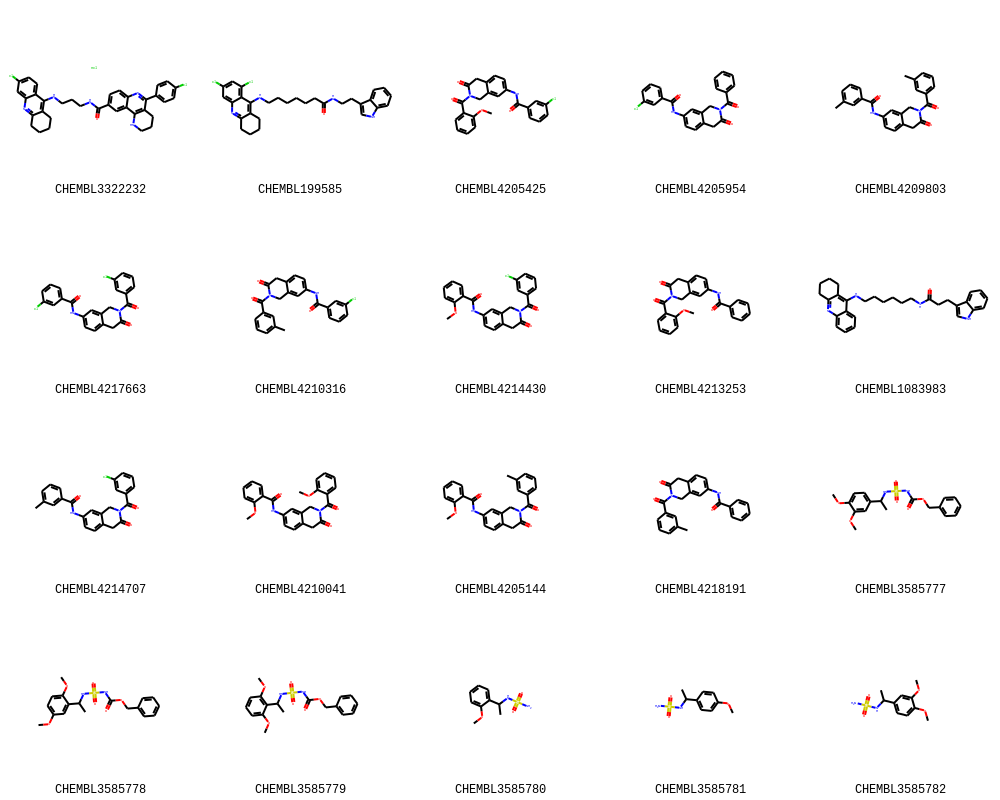

In [ ]:
ha_list = []
smile_2_mol(HA_data_20, ha_list)

Draw.MolsToGridImage(ha_list, molsPerRow=5, legends=[str(x) for x in HA_data_20.molecule_chembl_id])

We see some similar looking compounds. Maybe worth looking at associated literature.

## **Exploratory Data Analysis**

Exploring and analysing chemical space using the molecular and lipinski descriptors.

### **Bioactivity Histogram**

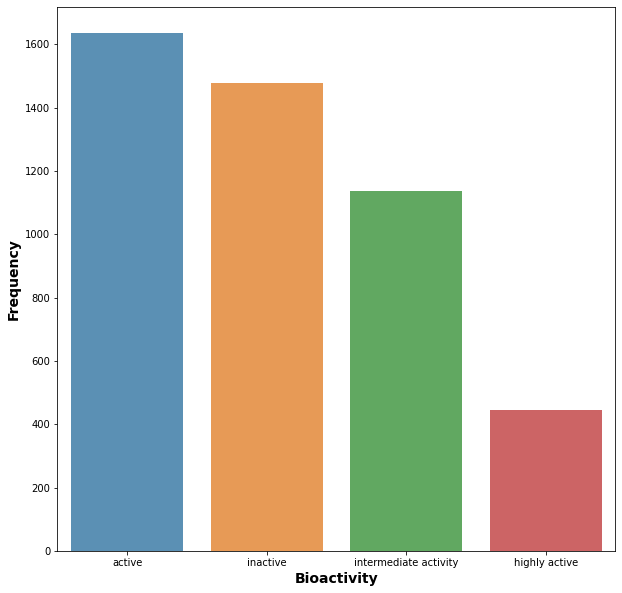

In [ ]:
plt.figure(figsize=(10,10))

sbn.countplot(x='bioactivity', data=combined_info, alpha=0.8)

plt.xlabel('Bioactivity', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.show()
# plt.savefig('bioactivity_frequency.png')

### **Shared Features**

#### **Molecular Weight vs LogP**

There were a lot of "inactive" compounds found. Do the inactive and active compounds share similar features? Like MW and LogP

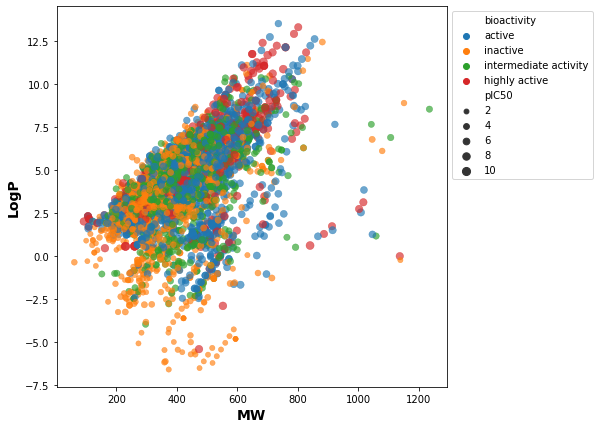

In [ ]:
plt.figure(figsize=(7,7))

sbn.scatterplot(x='MW', y='LogP', data=combined_info, hue='bioactivity', size='pIC50', edgecolor=None, alpha=0.65)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()
# plt.savefig('MW_vs_LogP.png')

Let's remove compounds with intermediate activity for a clearer look at the way each bioactivity spans the chemical space.

In [ ]:
final_no_int = combined_info[combined_info['bioactivity'] !='intermediate activity']

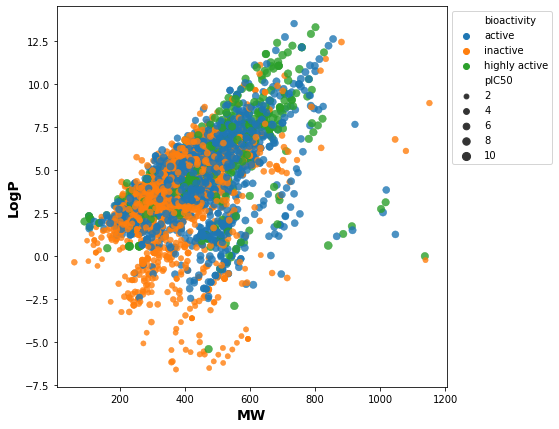

In [ ]:
plt.figure(figsize=(7,7))

sbn.scatterplot(x='MW', y='LogP', data=final_no_int, hue='bioactivity', size='pIC50', edgecolor=None, alpha=0.8)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()
# plt.savefig('MW_vs_LogP.png')

## **Investigating the distribution of bioactivity with different properties**

### **pIC50**

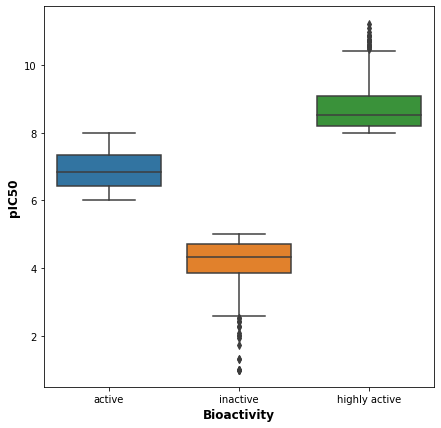

In [ ]:
plt.figure(figsize=(7,7))

sbn.boxplot(x='bioactivity', y='pIC50', data=final_no_int)

plt.xlabel('Bioactivity', fontsize=12, fontweight='bold')
plt.ylabel('pIC50', fontsize=12, fontweight='bold')
plt.show()
# plt.savefig('distr_pIC50.png')

### **MW**

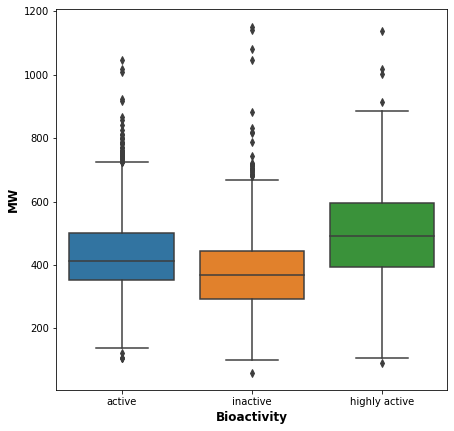

In [ ]:
plt.figure(figsize=(7,7))

sbn.boxplot(x='bioactivity', y='MW', data=final_no_int)

plt.xlabel('Bioactivity', fontsize=12, fontweight='bold')
plt.ylabel('MW', fontsize=12, fontweight='bold')
plt.show()
# plt.savefig('distr.png')

### **H-acceptors**

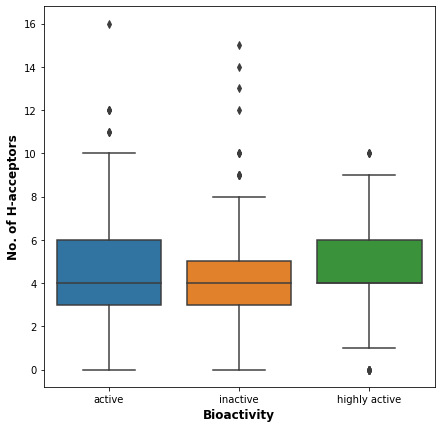

In [ ]:
plt.figure(figsize=(7,7))

sbn.boxplot(x='bioactivity', y='No_H-Acceptors', data=final_no_int)

plt.xlabel('Bioactivity', fontsize=12, fontweight='bold')
plt.ylabel('No. of H-acceptors', fontsize=12, fontweight='bold')
plt.show()
# plt.savefig('distr.png')

### **H-donors**

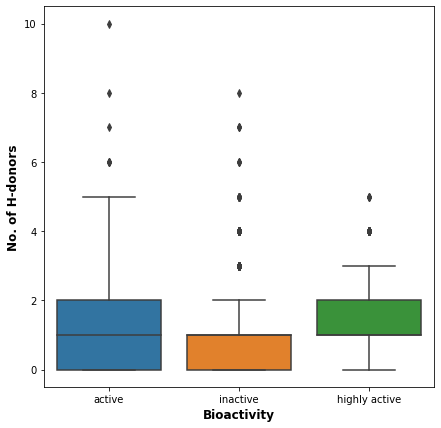

In [ ]:
plt.figure(figsize=(7,7))

sbn.boxplot(x='bioactivity', y='No_H-Donors', data=final_no_int)

plt.xlabel('Bioactivity', fontsize=12, fontweight='bold')
plt.ylabel('No. of H-donors', fontsize=12, fontweight='bold')
plt.show()
# plt.savefig('distr.png')

### **LogP**

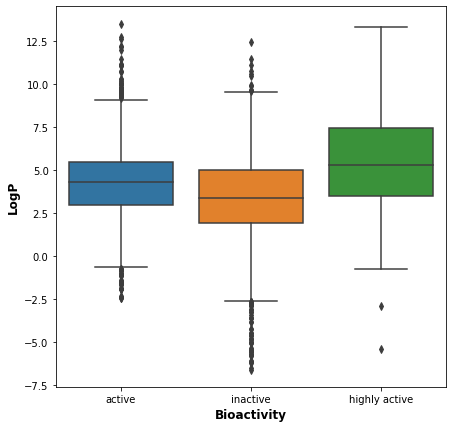

In [ ]:
plt.figure(figsize=(7,7))

sbn.boxplot(x='bioactivity', y='LogP', data=final_no_int)

plt.xlabel('Bioactivity', fontsize=12, fontweight='bold')
plt.ylabel('LogP', fontsize=12, fontweight='bold')
plt.show()
# plt.savefig('distr.png')

## **The Mann-Whitney U Test**

Let's investigate the statistical differences between the active and highly active molecules for each property/descriptor.

A p below our $\alpha$ can be intepretted as the showing statistically significant differences.

https://www.statstutor.ac.uk/resources/uploaded/mannwhitney.pdf

**We don't need to do the Mann-Whit test on pIC50 as we classed them**

In [ ]:
mannwhitney_act_vs_hi_act('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,267095.5,5.544705e-18,0.05,Different distribution (reject null hyp)


In [ ]:
mannwhitney_act_vs_hi_act('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,269354.5,3.115831e-17,0.05,Different distribution (reject null hyp)


In [ ]:
mannwhitney_act_vs_hi_act('No_H-Donors')

,Descriptor,Statistics,p,alpha,Interpretation
0,No_H-Donors,294505.0,7.631911e-11,0.05,Different distribution (reject null hyp)


In [ ]:
mannwhitney_act_vs_hi_act('No_H-Acceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,No_H-Acceptors,341918.0,0.027075,0.05,Different distribution (reject null hyp)


# **Building Predictive Models of binding affinity (pIC50) using PubChem Fingerprints of AChE inhibitors**

numerical representation of key substructures.

The RDKit descriptors we used above could also be used to train our model.

Chem.RDKitDescriptors featurizes a molecule, which can then be used to train a model in DeepChem for example.

https://github.com/deepchem/deepchem/blob/master/examples/tutorials/07_Going_Deeper_on_Molecular_Featurizations.ipynb

## **Using PaDEL-Descriptor**

PaDEL-Descriptor is an open-source software used to calculate molecular descriptors and fingerprints.

https://onlinelibrary.wiley.com/doi/10.1002/jcc.21707

http://www.yapcwsoft.com/dd/padeldescriptor/

https://github.com/ECRL/PaDELPy

### **via python PaDELPy**

In [ ]:
#! pip install padelpy

In [ ]:
#from padelpy import from_smiles

Let's extract the column headers

In [ ]:
#click = from_smiles(combined_info.canonical_smiles[0], fingerprints=True, descriptors=False)
#hokei = pd.DataFrame.from_dict(dict.items(click)).drop(1, axis=1).T
#header = hokei.values.tolist()

In [ ]:
#header = []
#for i in range(881):
#  header.append('PubchemFP{}'.format(i))

Now we convert every smile in our "combined_info" dataframe into their respective pubchem fingerprints using PaDELPy. 

PaDELPy outputs the fingerprints as a dictionary. Thus, we need to convert the output into a dataframe, remove the fingerprint label, transpose the dataframe and then append them together.

In [ ]:
#pubchem_finga = pd.DataFrame()
#for i in combined_info.canonical_smiles:
#  pc_fp = from_smiles(i, fingerprints=True,descriptors=False, timeout=60)
#  row = pd.DataFrame.from_dict(dict.items(pc_fp)).drop(0, axis=1).T
#  pubchem_finga = pubchem_finga.append(row)

#pubchem_finga

In [ ]:
#pubchem_finga

Re-apply our column headers, reset the index and our data is ready to go.

In [ ]:
#df_pf = pubchem_finga.reset_index(drop=True)
#df_pf.columns = header
#df_pf

In [ ]:
#Y = combined_info['pIC50']
#Y

In [ ]:
#pc_fp_pIC50_data = pd.concat([df_pf,Y], axis=1)
#pc_fp_pIC50_data

In [ ]:
#pc_fp_pIC50_data.to_csv('AChE_pc_fp_vs_pIC50_data.csv', index=False)

### **PaDEL.sh**

**Iterating through the list of canonical smiles using PaDELPy is a very attractive method at first, however, it takes way too long. We only made our way through a 3rd of the dataframe over the course of 8 hours.**

Instead we can use a bash script to run PaDEL within this notebook.

https://github.com/phi-grib/PaDEL-descriptor-ws

https://stackoverflow.com/questions/43972179/padel-descriptor-on-command-line

In [ ]:
! wget https://github.com/muyonaise/projects/raw/main/padel.zip
! wget https://raw.githubusercontent.com/muyonaise/projects/main/padel.sh 

--2020-11-22 16:38:50--  https://github.com/muyonaise/projects/raw/main/padel.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/muyonaise/projects/main/padel.zip [following]
--2020-11-22 16:38:51--  https://raw.githubusercontent.com/muyonaise/projects/main/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip.2’

padel.zip.2         100%[===================>]  24.57M  45.6MB/s    in 0.5s    

2020-11-22 16:38:53 (45.6 MB/s) - ‘padel.zip.2’ saved [25768637/25768637]

--2020-11-22 16:38:53--  https://raw.githubusercontent.com/muyonaise/projec

In [ ]:
! unzip padel.zip

Archive:  padel.zip
replace __MACOSX/._PaDEL-Descriptor? [y]es, [n]o, [A]ll, [N]one, [r]ename: NN


In [ ]:
smi_file = combined_info[['canonical_smiles','molecule_chembl_id']]
# save the file (to a smi file using tab as our separator)
smi_file.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
# contains smile notation (the chemical info) and the chembl id
# first 5 molecules in .smi file matches the first 5 id's in dataframe
! cat molecule.smi | head -5

CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1	CHEMBL133897
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1	CHEMBL336398
CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1	CHEMBL131588
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F	CHEMBL130628
CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1	CHEMBL130112


In [ ]:
# check last 5 also
! cat molecule.smi | tail -5

CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)CC2)cc(C(C)(C)C)c1O	CHEMBL4281727
CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=O)[O-])c3)CC2)cc(C(C)(C)C)c1O	CHEMBL4292349
CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(C#N)cc3)CC2)cc(C(C)(C)C)c1O	CHEMBL4278260
O=C(/C=C/c1ccccc1)NCCC1CCN(Cc2ccccc2)CC1	CHEMBL3819548
O=C(/C=C/c1ccc(O)cc1)NCCC1CCN(Cc2ccccc2)CC1	CHEMBL3819320


In [ ]:
# check that all the rows have been correctly saved
! cat molecule.smi | wc -l

4695


In [ ]:
# padel.sh is a bash script that that uses java to calc these descriptors
# set to use 1gb of mem, -jar uses Padel-Descriptor.jar file
# salts (Na & Cl) are removed from the chemical structure aka cleans the chemical structure of impurities
# standardizenitro standardizes nitrogen bond-lengths maybe? Or cleans it of nitrates?
# computing fingerprints with -fingerprints in the PubChem fingerprint format
# outputs descriptors into a csv file
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
! bash padel.sh

Processing CHEMBL133897 in molecule.smi (1/4695). 
Processing CHEMBL336398 in molecule.smi (2/4695). 
Processing CHEMBL131588 in molecule.smi (3/4695). Average speed: 6.39 s/mol.
Processing CHEMBL130628 in molecule.smi (4/4695). Average speed: 3.30 s/mol.
Processing CHEMBL130112 in molecule.smi (5/4695). Average speed: 2.50 s/mol.
Processing CHEMBL130098 in molecule.smi (6/4695). Average speed: 1.95 s/mol.
Processing CHEMBL337486 in molecule.smi (7/4695). Average speed: 1.65 s/mol.
Processing CHEMBL336538 in molecule.smi (8/4695). Average speed: 1.42 s/mol.
Processing CHEMBL341437 in molecule.smi (9/4695). Average speed: 1.29 s/mol.
Processing CHEMBL335033 in molecule.smi (10/4695). Average speed: 1.14 s/mol.
Processing CHEMBL122983 in molecule.smi (11/4695). Average speed: 1.07 s/mol.
Processing CHEMBL338720 in molecule.smi (12/4695). Average speed: 1.00 s/mol.
Processing CHEMBL339995 in molecule.smi (13/4695). Average speed: 0.97 s/mol.
Processing CHEMBL335158 in molecule.smi (14/469

In [ ]:
ls -l

total 92252
-rw-r--r-- 1 root root  3562870 Nov 22 16:38 AChE_chembl_inhib_ic50_raw.csv
-rw-r--r-- 1 root root   628414 Nov 22 16:38 AChE_mol_lipinski_desc_pIC50.csv
-rw-r--r-- 1 root root  4253873 Nov 22 15:25 AChE_pc_fp_vs_pIC50_data.csv
-rw-r--r-- 1 root root  8356701 Nov 22 17:06 descriptors_output.csv
-rw-r--r-- 1 root root        0 Nov 22 09:45 logs.log
drwxr-xr-x 3 root root     4096 Nov 22 09:25 __MACOSX/
-rw-r--r-- 1 root root   310658 Nov 22 16:46 molecule.smi
drwxrwxr-x 4 root root     4096 May 30 10:10 PaDEL-Descriptor/
-rw-r--r-- 1 root root      231 Nov 22 09:25 padel.sh
-rw-r--r-- 1 root root      231 Nov 22 09:49 padel.sh.1
-rw-r--r-- 1 root root      231 Nov 22 16:38 padel.sh.2
-rw-r--r-- 1 root root 25768637 Nov 22 09:25 padel.zip
-rw-r--r-- 1 root root 25768637 Nov 22 09:49 padel.zip.1
-rw-r--r-- 1 root root 25768637 Nov 22 16:38 padel.zip.2
drwxr-xr-x 1 root root     4096 Nov 13 17:33 sample_data/


#### **X & Y matrices**

In [ ]:
df_pf = pd.read_csv('descriptors_output.csv')

In [ ]:
df_pf_X = df_pf.drop(labels='Name', axis=1)

df_pf_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4690,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4691,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4692,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4693,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
Y = combined_info['pIC50']
Y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       5.619789
          ...   
4690    5.419075
4691    5.460924
4692    5.555955
4693    6.346787
4694    5.600326
Name: pIC50, Length: 4695, dtype: float64

In [ ]:
pc_fp_pIC50_data = pd.concat([df_pf_X,Y], axis=1)
pc_fp_pIC50_data

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.124939
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.000000
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.301030
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.522879
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.619789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4690,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.419075
4691,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.460924
4692,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.555955
4693,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.346787


In [ ]:
pc_fp_pIC50_data.to_csv('AChE_pc_fp_vs_pIC50_data.csv', index=False)

## **Building our predictive models**

Let's first remove low variance features (fingerprints). Removing unnecessary features can simplify our models, reducing its parameters, thus its ease of interpretation and shorten our training time!!!

In [ ]:
from sklearn.feature_selection import VarianceThreshold
# remove all features that are either one or zero (on or off) in more than 80% of the inputs
ft_selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = ft_selection.fit_transform(df_pf_X)
X.shape

(4695, 137)

In [ ]:
# for PyCaret?
X_split = X
Y_split = Y

### **scikit-learn**

#### **Modelling**

Let's split our data into a training and test set. We will train with 80% of our data and test with the rest, also we won't shuffle the data.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_split, Y_split, train_size=0.8)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,Y_train)

LinearRegression()

In [ ]:
# we apply the model on the x_train to see what it predicts "y_pred"
Y_pred_train = lin_reg.predict(X_train)

In [ ]:
# we print the mean squared error
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train))
# R^2 = pearsons correlation coefficient squared
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Mean squared error (MSE): 1.58
Coefficient of determination (R^2): 0.32


Using our fitted model on the test set

In [ ]:
Y_pred_test = lin_reg.predict(X_test)

In [ ]:
print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (MSE): 1.82
Coefficient of determination (R^2): 0.26


#### **Plots**

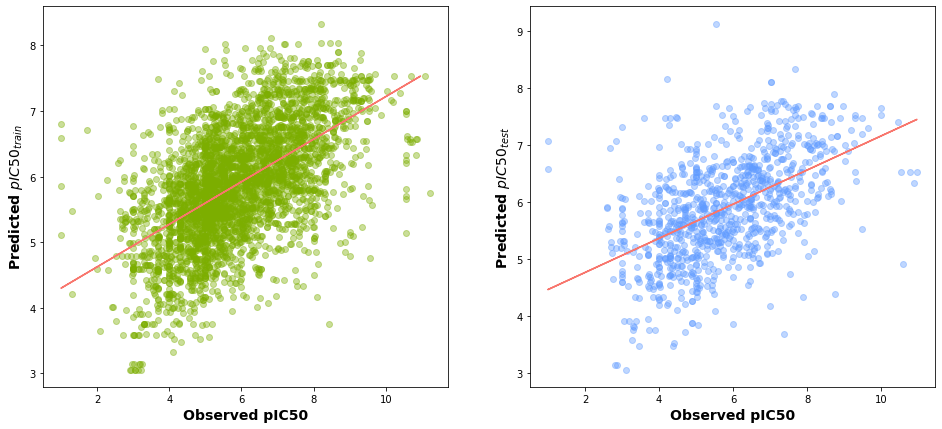

In [ ]:
plt.figure(figsize=(16,7))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)
# setting colour and position of plot 1 with a red line of best fit
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=0.4)

z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel(r'Predicted $pIC50_{train}$', fontsize=14, fontweight='bold')
plt.xlabel('Observed pIC50', fontsize=14, fontweight='bold')

# 1 row, 2 column, plot 2
plt.subplot(1, 2, 2)

plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=0.4)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel(r'Predicted $pIC50_{test}$', fontsize=14, fontweight='bold')
plt.xlabel('Observed pIC50', fontsize=14, fontweight='bold')

#plt.savefig('sklearn_pIC50.png')
#plt.savefig('sklearn_pIC50.pdf')
plt.show()

### **PyCaret**

#### **Modelling**

PyCaret is a low-code ML library that allows one to quickly analyse many models.

https://pycaret.org/

In [ ]:
! pip install pycaret

In [ ]:
# https://pycaret.org/regression/
from pycaret.regression import *

In [ ]:
# pycarets setup function creates our model. We set our train set to be 80% of the dataset
# we set our Y (the column we want to predict) using the target parameter
# silent=true sets message prompts to not show
# ignore_low_variance = True, removes low variance features (ones that are tres similare)
# NOTE: ONE CANNOT USE sklearn.model_selection.train_test_split module at the same time
# raises error as it confuses pycaret's setup() module
model = setup(data= pc_fp_pIC50_data, target= 'pIC50', silent=True, ignore_low_variance = True)

,Description,Value
0,session_id,471
1,Target,pIC50
2,Original Data,"(4695, 882)"
3,Missing Values,False
4,Numeric Features,0
5,Categorical Features,881
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3286, 275)"


We see PyCaret's calculation of low-variance features left us with 277 features, compared to the 137 above.

Now compare various models

In [ ]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,7.799000e-01,1.177700e+00,1.083500e+00,5.009000e-01,0.1690,1.520000e-01,0.243
catboost,CatBoost Regressor,7.666000e-01,1.183300e+00,1.085600e+00,4.987000e-01,0.1694,1.500000e-01,12.486
rf,Random Forest Regressor,7.736000e-01,1.250100e+00,1.115300e+00,4.711000e-01,0.1736,1.512000e-01,6.003
knn,K Neighbors Regressor,8.119000e-01,1.305600e+00,1.141100e+00,4.473000e-01,0.1774,1.584000e-01,0.475
gbr,Gradient Boosting Regressor,8.829000e-01,1.346500e+00,1.159300e+00,4.298000e-01,0.1799,1.723000e-01,1.561
xgboost,Extreme Gradient Boosting,8.045000e-01,1.348300e+00,1.158500e+00,4.291000e-01,0.1804,1.563000e-01,3.212
ridge,Ridge Regression,9.444000e-01,1.523300e+00,1.232800e+00,3.555000e-01,0.1899,1.824000e-01,0.040
br,Bayesian Ridge,9.529000e-01,1.530300e+00,1.235800e+00,3.523000e-01,0.1896,1.839000e-01,0.177
huber,Huber Regressor,9.493000e-01,1.569800e+00,1.251900e+00,3.354000e-01,0.1920,1.821000e-01,0.883
omp,Orthogonal Matching Pursuit,1.025200e+00,1.727800e+00,1.313100e+00,2.698000e-01,0.2006,1.977000e-01,0.041


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=471, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

As expected PyCaret gives us very similar metrics to the calculation we did above with sklearn, which gave:

Mean squared error (MSE): 1.61

Coefficient of determination (R^2): 0.32

We create our model and below shows the performance of the model over 10 cross validations with the mean performance and the standard deviation. Let's choose the catboost model (though it was the slowest too)

https://www.dezyre.com/recipes/use-catboost-classifier-and-regressor-in-python

In [ ]:
ctb = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.8346,1.4339,1.1975,0.4199,0.1927,0.1733
1,0.7708,1.1503,1.0725,0.5245,0.1733,0.1595
2,0.7336,1.0804,1.0394,0.5278,0.1576,0.1368
3,0.7658,1.2047,1.0976,0.4879,0.1695,0.1511
4,0.7856,1.2087,1.0994,0.5119,0.1682,0.1465
5,0.7864,1.2905,1.1360,0.4253,0.1790,0.1577
6,0.6860,0.9709,0.9853,0.5847,0.1568,0.1360
7,0.8480,1.4166,1.1902,0.4072,0.1815,0.1658
8,0.7295,1.0662,1.0326,0.4754,0.1569,0.1332
9,0.7261,1.0106,1.0053,0.6224,0.1586,0.1400


The CatBoost model certainly improves on the R^2 and MSE obtained from the linear regression model

We can then fine tune our parameters over a given number of iterations based off optimizing a given metric

In [ ]:
tuned_ctb = tune_model(ctb, n_iter = 10, optimize = 'r2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.8873,1.4133,1.1888,0.4282,0.1922,0.1832
1,0.8424,1.2308,1.1094,0.4913,0.1796,0.1752
2,0.7976,1.1797,1.0861,0.4844,0.1659,0.1521
3,0.8211,1.2149,1.1022,0.4836,0.1711,0.1621
4,0.8331,1.2077,1.0990,0.5123,0.1684,0.1563
5,0.8289,1.2966,1.1387,0.4225,0.1797,0.1663
6,0.7503,1.0048,1.0024,0.5701,0.1585,0.1469
7,0.8879,1.3512,1.1624,0.4345,0.1782,0.1723
8,0.7419,1.0389,1.0193,0.4888,0.1552,0.1372
9,0.7971,1.1276,1.0619,0.5786,0.1656,0.1524


we can test both models on the test set to see if we might've over fit

In [ ]:
pyc_testset_pred = predict_model(ctb)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.7282,1.0419,1.0207,0.5527,0.1572,0.1383


In [ ]:
pyc_testset_pred = predict_model(tuned_ctb)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.816,1.1891,1.0904,0.4895,0.1682,0.1573


#### **Plots**

pycaret offers many quick ways to plot very informative graphs

https://pycaret.org/plot-model/

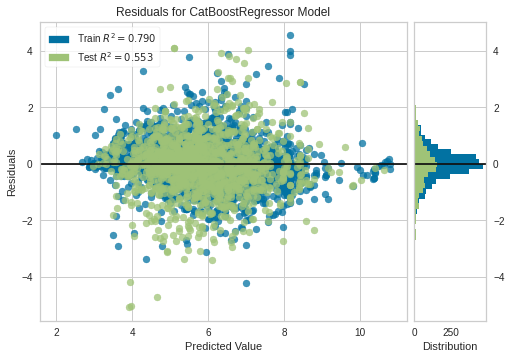

In [ ]:
plot_model(ctb, 'residuals')

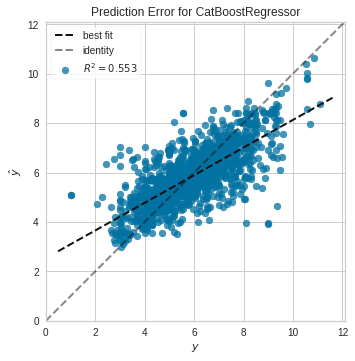

In [ ]:
# scatter plot of actual value vs predicted value!
plot_model(ctb, 'error')

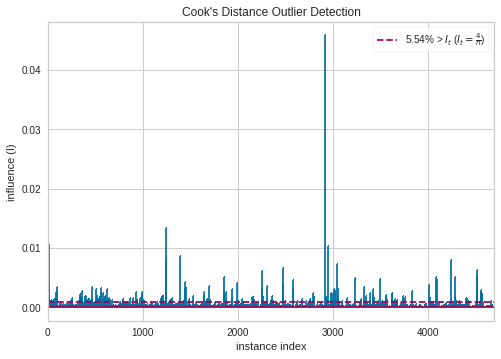

In [ ]:
# for outlier detection
plot_model(ctb, 'cooks')

IntProgress(value=0, description='Processing: ', max=5)

KeyboardInterrupt: ignored

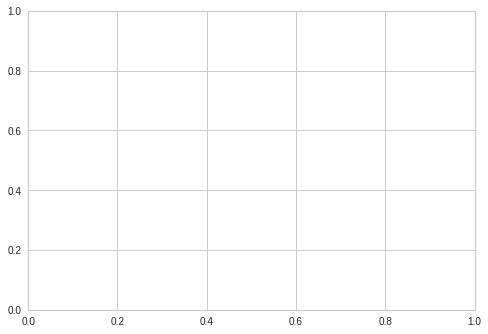

In [ ]:
# to help determine important features
# reducing features to simiplify our model (increase speed) but still managing to maintain
# a high degree of accuracy
plot_model(ctb, 'rfe')

In [ ]:
plot_model(ctb, 'feature')

In [ ]:
# evaluate_model displays all available plots
evaluate_model(tuned_ctb)

### **DeepChem**

Open source comp & quantum chem tool developed by Bharath Ramsundar

https://deepchem.io/

https://arxiv.org/abs/1703.00564

DeepChem supports PubChem fingerprints. It also supports Extended Connectivity Fingerprints (ECFP), which classify atoms based on their environments.

#### **Installation**

In [ ]:
# import deepchem
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3490  100  3490    0     0   8925      0 --:--:-- --:--:-- --:--:--  8925


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added omnia to channels
added conda-forge to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [ ]:
!pip install --pre deepchem

     |████████████████████████████████| 409kB 4.2MB/s 
  Created wheel for deepchem: filename=deepchem-2.4.0rc1.dev20201122172714-cp36-none-any.whl size=516373 sha256=62ac3e0b94ef7f4eba089013f213d8bf8302c9be3f4991799a60ed225316c2a5
  Stored in directory: /root/.cache/pip/wheels/d3/85/9a/a923bd2c2cbc8d2753910b49412e3e442b4c601d16d1208370
Successfully built deepchem


In [ ]:
import deepchem as dc
import numpy as np
import tensorflow as tf
from deepchem.models import GraphConvModel

#### **Coupling DeepChem with sklearn for a Random Forest model using extended connectivity (circular) fingerprints**

**Loading and preparing our data**

In [ ]:
dc_data = pd.concat([combined_info["canonical_smiles"], combined_info["pIC50"]], axis=1)
dc_data

,canonical_smiles,pIC50
0,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,6.124939
1,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,7.000000
2,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,4.301030
3,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,6.522879
4,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,5.619789
...,...,...
4690,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(Br)cc3)...,5.419075
4691,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3cccc([N+](=...,5.460924
4692,CC(C)(C)c1cc(/C=C/C(=O)NCCC2CCN(Cc3ccc(C#N)cc3...,5.555955
4693,O=C(/C=C/c1ccccc1)NCCC1CCN(Cc2ccccc2)CC1,6.346787


In [ ]:
# set our featurizer (the way we process/input our X aka our features)
# the circular fingerprint featurizer transforms SMILES into extended connectivity (circular) fingerprints, 
featurizer = dc.feat.CircularFingerprint(size=1024)
# Featurizer could also be ECFP (https://docs.chemaxon.com/display/docs/extended-connectivity-fingerprint-ecfp.md)
moles = [Chem.MolFromSmiles(smiles) for smiles in dc_data["canonical_smiles"]]
features = featurizer.featurize(moles)
dataset = dc.data.NumpyDataset(
    X=features, y=dc_data["pIC50"], ids=dc_data["canonical_smiles"])

print("Data converted into DeepChem Dataset")
print(dataset)


Data converted into DeepChem Dataset
<NumpyDataset X.shape: (4695, 1024), y.shape: (4695,), w.shape: (4695,), task_names: [0]>


In [ ]:
# Initialize transformers
transformers = [
                dc.trans.NormalizationTransformer(
                    transform_y=True,dataset=dataset
                )
]

print("Transforming data")
for transformer in transformers:
  dataset = transformer.transform(dataset)


dataset

Transforming data


<NumpyDataset X.shape: (4695, 1024), y.shape: (4695,), w.shape: (4695,), task_names: [0]>

In [ ]:
# Split our dataset by index
# we will separate the data by index. but we could also shuffle the data randomly
# could also use a chemically aware splitting method like Murcko scaffolds
# https://www.rdkit.org/docs/source/rdkit.Chem.Scaffolds.MurckoScaffold.html
# https://github.com/deepchem/deepchem/blob/master/deepchem/splits/splitters.py
splitter = dc.splits.IndexSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

In [ ]:
print(train_dataset)

<NumpyDataset X.shape: (3756, 1024), y.shape: (3756,), w.shape: (3756,), task_names: [0]>


 **Setting up and fitting our model**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# rf is a bagging technique not a boosting technique. (A model comprised of many models) aka an ensemble model
# the trees (pathways) in rf run in parallel but there is no interaction between trees while building the network
# very accurate learning algorithm but can result in overfitting
# no. of estimators = number of trees
regressor = RandomForestRegressor(n_estimators=100)
rf_model = dc.models.SklearnModel(regressor)
rf_model.fit(train_dataset)

**Evaluating our model**

In [ ]:
# set our metrics
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)

print("Evaluating model")
train_scores = rf_model.evaluate(train_dataset, [metric], transformers)
valid_scores = rf_model.evaluate(valid_dataset, [metric], transformers)

print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

Evaluating model
Train scores
{'mean-pearson_r2_score': 0.947554273767458}
Validation scores
{'mean-pearson_r2_score': 0.46691801324216253}


**Optimizing our model**

https://depth-first.com/articles/2020/09/14/getting-started-with-deepchem/

In [ ]:
# We can optimize our hyperparamters. The below function uses
# the number of trees in the forest (n_estimators) and the number of features
# we consider when splitting (max_features)

def rf_model_builder(n_estimators, max_features, model_dir):
  sklearn_model = RandomForestRegressor(
      n_estimators=n_estimators, max_features=max_features)
  return dc.models.SklearnModel(sklearn_model, model_dir)
params_dict = {
    "n_estimators": [10, 100],
    "max_features": ["auto", "sqrt", "log2", None],
}

# we can use DeepChem's GridHyperparamOpt to optimize our model

optimizer = dc.hyper.GridHyperparamOpt(rf_model_builder)
opt_rf, opt_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

**Re-evaluate**

In [ ]:
print("Evaluating model")
train_scores = opt_rf.evaluate(train_dataset, [metric], transformers)
valid_scores = opt_rf.evaluate(valid_dataset, [metric], transformers)
test_scores = opt_rf.evaluate(test_dataset, [metric], transformers)

print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

print("Test scores")
print(test_scores)

**Plotting our model**

In [ ]:
predicted_test = opt_rf.predict(test_dataset)
measured_test = test_dataset.y

plt.scatter(predicted_test, measured_test)
plt.xlabel('Predicted Bioacitivity, pIC50')
plt.ylabel('Measured Bioacitivity, pIC50')
plt.title(r'Random Forest Predicted vs. Measured Activities')
plt.show()

#### **RF model using PubChemFP**

In [ ]:
# must install PubChemPy to use pubchem featurizer in DeepChem
! pip install PubChemPy

In [ ]:
featurizer = dc.feat.PubChemFingerprint()

moles = [Chem.MolFromSmiles(smiles) for smiles in dc_data["canonical_smiles"]]
features = featurizer.featurize(moles)
dataset = dc.data.NumpyDataset(
    X=features, y=dc_data["pIC50"], ids=dc_data["canonical_smiles"])

print("Data converted into DeepChem Dataset")
print(dataset)

# Initialize transformers
transformers = [
                dc.trans.NormalizationTransformer(
                    transform_y=True,dataset=dataset
                )
]

print("Transforming data")
for transformer in transformers:
  dataset = transformer.transform(dataset)

splitter = dc.splits.IndexSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

KeyboardInterrupt: ignored

In [ ]:
regressor = RandomForestRegressor(n_estimators=100)
rf_model = dc.models.SklearnModel(regressor)
rf_model.fit(train_dataset)

In [ ]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)

print("Evaluating model")
train_scores = rf_model.evaluate(train_dataset, [metric], transformers)
valid_scores = rf_model.evaluate(valid_dataset, [metric], transformers)

print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

#### **RF model using RDKit Descriptors**

In [ ]:
featurizer = dc.feat.RDKitDescriptors()

moles = [Chem.MolFromSmiles(smiles) for smiles in dc_data["canonical_smiles"]]
features = featurizer.featurize(moles)
dataset = dc.data.NumpyDataset(
    X=features, y=dc_data["pIC50"], ids=dc_data["canonical_smiles"])

print("Data converted into DeepChem Dataset")
print(dataset)

# Initialize transformers
transformers = [
                dc.trans.NormalizationTransformer(
                    transform_y=True,dataset=dataset
                )
]

print("Transforming data")
for transformer in transformers:
  dataset = transformer.transform(dataset)

splitter = dc.splits.IndexSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

Data converted into DeepChem Dataset
<NumpyDataset X.shape: (4695, 115), y.shape: (4695,), w.shape: (4695,), task_names: [0]>
Transforming data


#### **A Graph Convolution Neural Network using molecular graphs**

In [ ]:
featurizer = dc.feat.ConvMolFeaturizer()

moles = [Chem.MolFromSmiles(smiles) for smiles in dc_data["canonical_smiles"]]
features = featurizer.featurize(moles)
dataset = dc.data.NumpyDataset(
    X=features, y=dc_data["pIC50"], ids=dc_data["canonical_smiles"])

print("Data converted into DeepChem Dataset")
print(dataset)


Data converted into DeepChem Dataset
<NumpyDataset X.shape: (4695,), y.shape: (4695,), w.shape: (4695,), task_names: [0]>


In [ ]:
# Initialize transformers
transformers = [
                dc.trans.NormalizationTransformer(
                    transform_y=True,dataset=dataset
                )
]

print("Transforming data")
for transformer in transformers:
  dataset = transformer.transform(dataset)

Transforming data


<NumpyDataset X.shape: (4695,), y.shape: (4695,), w.shape: (4695,), task_names: [0]>

In [ ]:
splitter = dc.splits.IndexSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

<NumpyDataset X.shape: (3756,), y.shape: (3756,), w.shape: (3756,), task_names: [0]>


In [ ]:
# Number of features
n_feat = 75
# Batch size of models
batch_size = 128
# first argument is the number of tasks (number of Y's)
gcn_model = GraphConvModel(
    1, batch_size=batch_size, mode='regression')

In [ ]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)

# This calculation was not done on the GPU

gcn_model.fit(train_dataset, nb_epoch=20)

print("Evaluating model")
train_scores = gcn_model.evaluate(train_dataset, [metric], transformers)
valid_scores = gcn_model.evaluate(valid_dataset, [metric], transformers)

print("Train scores")
print(train_scores)

print("Validation scores")
print(valid_scores)

Evaluating model
Train scores
{'mean-pearson_r2_score': 0.8288216217023706}
Validation scores
{'mean-pearson_r2_score': 0.20886588895624997}


#### **Neural Networks using TensorFlow/Keras**

In [ ]:
featurizer = dc.feat.CircularFingerprint(size=1024)

moles = [Chem.MolFromSmiles(smiles) for smiles in dc_data["canonical_smiles"]]
features = featurizer.featurize(moles)
dataset = dc.data.NumpyDataset(
    X=features, y=dc_data["pIC50"], ids=dc_data["canonical_smiles"])

print("Data converted into DeepChem Dataset")
print(dataset)

transformers = [
                dc.trans.NormalizationTransformer(
                    transform_y=True,dataset=dataset
                )
]

print("Transforming data")
for transformer in transformers:
  dataset = transformer.transform(dataset)

splitter = dc.splits.IndexSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)

Data converted into DeepChem Dataset
<NumpyDataset X.shape: (4695, 1024), y.shape: (4695,), w.shape: (4695,), task_names: [0]>
Transforming data


In [ ]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(137, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(1)
])

#l2 = 0.5*np.mean(error**2)
tf_model = dc.models.KerasModel(keras_model, dc.models.losses.L2Loss())

In [ ]:
print(train_dataset)

<NumpyDataset X.shape: (3756, 1024), y.shape: (3756,), w.shape: (3756,), task_names: [0]>


In [ ]:
tf_model.fit(train_dataset, nb_epoch=50)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('training set score:', tf_model.evaluate(train_dataset, [metric]))
print('test set score:', tf_model.evaluate(test_dataset, [metric]))

training set score: {'pearson_r2_score': 0.951830859354452}
test set score: {'pearson_r2_score': 0.2097932976369763}


#### **Neural Networks with PyTorch**

In [ ]:
import torch

# let's make a sequential model with a 2 linear layers
# lets make the input sizes appropriate?
pytorch_model = torch.nn.Sequential(
    torch.nn.Linear(1024, 100),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(100, 1)
)

#l2 = 0.5*np.mean(error**2)
pyt_model = dc.models.TorchModel(pytorch_model, dc.models.losses.L2Loss())

pyt_model.fit(train_dataset, nb_epoch=50)
print('training set score:', pyt_model.evaluate(train_dataset, [metric]))
print('test set score:', pyt_model.evaluate(test_dataset, [metric]))

training set score: {'pearson_r2_score': 0.3891089850349155}
test set score: {'pearson_r2_score': 0.06551275065974203}


### **GCN using PyTorch Geometric**

A neural network build that looks really interesting, and worth exploring with more time is a GCN built with PyTorch Geometric

https://iwatobipen.wordpress.com/2019/04/05/make-graph-convolution-model-with-geometric-deep-learning-extension-library-for-pytorch-rdkit-chemoinformatics-pytorch/

Installation:
https://colab.research.google.com/drive/1mhsReNGfaSG8R_S5ZpbODTvGfb0YuI5C



*   **Optimization?**
*   **How to avoid overfitting?**
*   **Checking validation set w/ ea epoch?**
*   **Stopping early?**
*   **Regularization of loss functions?**



